In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# tqdm wrapper for joblib parallelization
import contextlib
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [92]:
# load in data
data = pd.read_csv('good_growth_updated.csv', header=None)

# clean data
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('good', '') # remove good
    text = text.replace('growth', '') # remove growth
    text = text.replace('"', '')
    text = text.replace('.', '')
    final = ''.join([i for i in text if not i.isdigit()])
    idx = 0
    while idx < len(final) - 1 and not final[idx].isalpha():
        idx += 1
    final = final[idx:]
    word_tokens = word_tokenize(final)
    final = " ".join([w for w in word_tokens if not w in stop_words])

    return final


data.rename(columns = {data.columns[0]: "text"}, inplace = True)
data['clean_text'] = data.text.apply(clean_text)
data.head()

[nltk_data] Downloading package stopwords to /Users/rohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,One of my favourite quotes is from Frederic La...,one favourite quotes frederic laloux : reached...
1,"Permissionless, as guarded by code. Inclusive,...","permissionless , guarded code inclusive , dict..."
2,Is the ability to take ideas and work solution...,ability take ideas work solutions refining alo...
3,Good growth means its more inclusive where eve...,means inclusive everyone n't gets zero sum gam...
4,Organic and intentional community proud of wha...,organic intentional community proud ’ achieved...


In [94]:
# get n-grams/keywords
import yake

kw_extractor = yake.KeywordExtractor()
language = "en"
deduplication_threshold = 0.9
numOfKeywords = 20

full_text = " ".join(data.clean_text) # join the clean text into a single string

f = open('n-grams.txt', 'w')
# get 1, 2, and 3-grams
for n in [1,2,3]:
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=n, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(full_text)
    f.write(f"{n}-grams\n")
    for kw in keywords:
        f.write(str(kw))
        f.write("\n")
    f.write("\n")

f.close()

In [95]:
# looking at frequent tokens which appear across the responses
with tqdm_joblib(tqdm(desc="Tokenization List", total=len(data))) as progress_bar:
    keyword_list = Parallel(n_jobs=3)(delayed(word_tokenize)(text) for text in data['clean_text'])

keyword_counter = Counter([item for sublist in keyword_list for item in sublist])
keyword_counter.most_common(15)

Tokenization List: 100%|██████████| 729/729 [00:11<00:00, 65.26it/s]


[(',', 1236),
 ('community', 252),
 ('people', 151),
 ("'s", 122),
 (')', 117),
 ('sustainable', 104),
 ('(', 101),
 ('would', 85),
 ('-', 73),
 ('positive', 70),
 ('new', 70),
 ('think', 67),
 ('grow', 66),
 ("n't", 65),
 ('growing', 64)]

In [97]:
# generate pairwise similiarity matrix for each document/response
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

documents = list(data['clean_text'])
vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
tfidf = vect.fit_transform(documents)                                                                                                                                                                                                                       
pairwise_similarity = tfidf * tfidf.T 
n, _ = pairwise_similarity.shape                                                                                                                                                                                                                         
pairwise_similarity[np.arange(n), np.arange(n)] = -1.0 # set diagonal entries negative (identical documents are similar)

/Users/rohan/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [98]:
# generate most and least similar documents for each response (top and bottom 3)
import json

x = pairwise_similarity.toarray()
mapping = []
n = 3
for i in range(len(x)):
    current_dict = {}
    law = x[i]
    y = (-law).argsort()[:n]
    z = (-law).argsort()[-n:]
    current_dict[data.text[i]] = {"most": [data.text[j] for j in y], "least": [data.text[j] for j in z]}
    mapping.append(current_dict)

with open("similar_responses.json", 'w') as f:
    json.dump(mapping, f)

len(mapping)

729

In [99]:
# vectorize and apply KMeans clustering with 5 clusteres
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(data['clean_text'])

from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

# use PCA to reduce the dimensionality of the data (went with 2 dimensions for easier visualization)
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [100]:
# generate top words for each cluster to analyze qualitative separation
data['cluster'] = clusters
data['x0'] = x0
data['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
world,better,think,knowledge,would,learning,new,impact,positive,people

Cluster 1
sustainable,users,long,driven,creating,positive,people,community,value,organic

Cluster 2
would,means,defined,values,building,people,product,members,growing,community

Cluster 3
driven,long,people,organic,equitable,term,community,benefit,inclusive,sustainable

Cluster 4
learn,project,something,people,term,others,long,making,development,grow


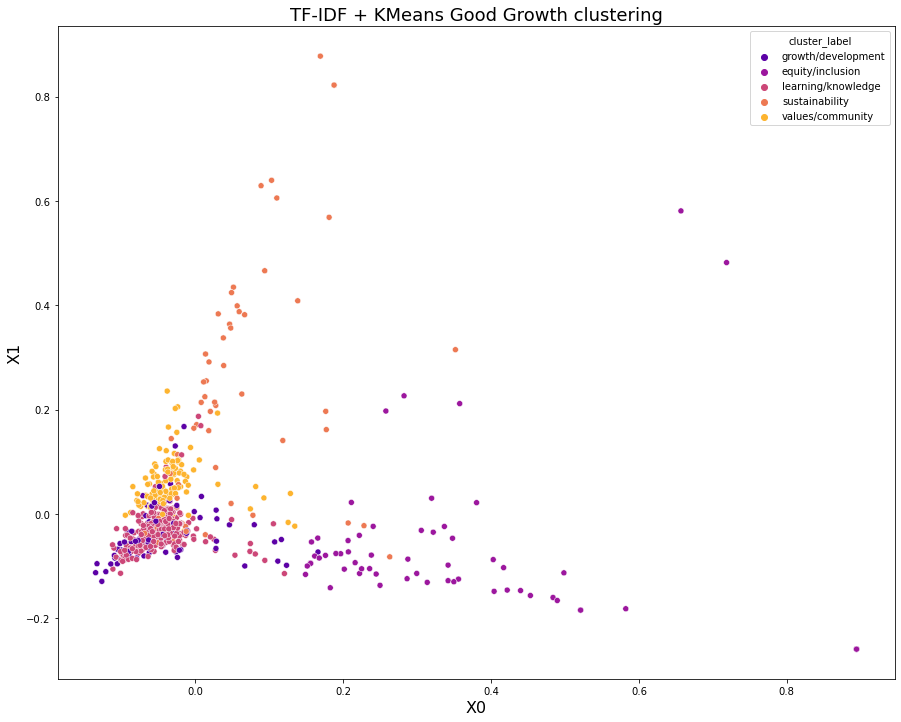

In [101]:
# plot clusters as components of the 2D PCA space
import seaborn as sns

cluster_map = {0: "learning/knowledge", 1: "sustainability", 2: "values/community", 3: "equity/inclusion", 4: "growth/development"}
data['cluster_label'] = data['cluster'].map(cluster_map)

plt.figure(figsize=(15, 12))
# set a title
plt.title("TF-IDF + KMeans Good Growth clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=data, x='x0', y='x1', hue='cluster_label', palette="plasma")
plt.show()

In [52]:
# get least common words across the responses (as outliers)
from nltk.tokenize import word_tokenize

tokens = word_tokenize(full_text)
f = open('outliers.txt', 'w')
for entry in Counter(tokens).most_common()[-50:]:
    f.write(entry)
    f.write("\n")

[('drawbacks', 1),
 ('longer-term', 1),
 ('decarbonize', 1),
 ('policymakers', 1),
 ('decentralizing', 1),
 ('racing', 1),
 ('crossing', 1),
 ('altogether', 1),
 ('foreseen', 1),
 ('shortcomings', 1),
 ('indeed', 1),
 ('observe', 1),
 ('lacked', 1),
 ('downfall', 1),
 ('countless', 1),
 ('short-sighted', 1),
 ('shallow', 1),
 ('decides', 1),
 ('apt', 1),
 ('quests', 1),
 ('accelerators', 1),
 ('disappointed', 1),
 ('centered', 1),
 ('valuations', 1),
 ('gross', 1),
 ('somebody', 1),
 ('diy', 1),
 ('music', 1),
 ('scene', 1),
 ('artist', 1),
 ('managing', 1),
 ('bands', 1),
 ('earn', 1),
 ('fake', 1),
 ('artistic', 1),
 ('pondering', 1),
 ('cash', 1),
 ("'slow", 1),
 ("'nurturing", 1),
 ('resistance', 1),
 ('immediacy', 1),
 ('annoying', 1),
 ('evaluating', 1),
 ('defining', 1),
 ('strategizing', 1),
 ('prioritizing', 1),
 ('sincerity', 1),
 ('allure', 1),
 ('vanity', 1),
 ('tied', 1)]

## Wordclouds

I'm going to start with wordclouds because people are familiar with them and are straightforward to interpret. 

In [14]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'nltk'

In [ ]:
cloud = WordCloud(
    background_color="white",
    max_words=20, 
    stopwords=stopwords.words('english'))


In [ ]:
## get text
## i removed "good" and "growth" from this version of the dataset
goodGrowth = " ".join(texty for texty in data.text)


In [ ]:
## plotyplotthewordplot
generic_cloud = WordCloud().generate(goodGrowth)


In [ ]:
## visualize generic wordcloud
firstPlot = plt.figure(figsize=(6, 6))

plt.imshow(generic_cloud, interpolation='bilinear')
plt.show()

In [ ]:
## some adjustments
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(goodGrowth)

plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


## Clusters
The wordcloud more or answers how frequent certain keywords are. So next I'll do topic clusters -- what topics emerge from the answers and how do the topics compare to each other?

In [57]:
import gensim
from gensim import corpora
from pprint import pprint
from gensim.test.utils import common_texts
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

raw_clean_growth = pd.read_csv('data/fresh_clean.csv')

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens_no_sw = [word for word in tokens if not word in stopwords.words()]
    return(tokens_no_sw)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amphiboly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
clean_documents = list(raw_clean_growth['text'])

In [59]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(clean_documents)):
    clean_documents[idx] = clean_documents[idx].lower()  # Convert to lowercase.
    clean_documents[idx] = tokenizer.tokenize(clean_documents[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
clean_documents = [[token for token in doc if not token.isnumeric()] for doc in clean_documents]

# Remove words that are only one character.
clean_documents = [[token for token in doc if len(token) > 1] for doc in clean_documents]


In [60]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')


lemmatizer = WordNetLemmatizer()
clean_documents = [[lemmatizer.lemmatize(token) for token in doc] for doc in clean_documents]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amphiboly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/amphiboly/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [69]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(clean_documents, min_count=1)
for idx in range(len(clean_documents)):
    for token in bigram[clean_documents[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            clean_documents[idx].append(token)


In [70]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(clean_documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.5)


In [71]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in clean_documents]


In [72]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))


Number of unique tokens: 912
Number of documents: 390


In [73]:
# Train LDA model.

from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


In [74]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)


Average topic coherence: -7.5042.
[([(0.021343023, 'community'),
   (0.01371849, 'one'),
   (0.013718257, 'more'),
   (0.013716324, 'rather_than'),
   (0.0135203395, 'long_term'),
   (0.012211046, 'story'),
   (0.012211043, 'idea'),
   (0.012146256, 'way'),
   (0.009195938, 'there'),
   (0.009195627, 'look_like'),
   (0.009194261, 'the'),
   (0.008722973, 'value'),
   (0.008296266, 'a'),
   (0.007855242, 'sustainable'),
   (0.0076905387, 'mean'),
   (0.007689675, 'project'),
   (0.007688382, 'person'),
   (0.007688265, 'today'),
   (0.0076881084, 'in'),
   (0.007657114, 'term')],
  -5.677976598195376),
 ([(0.025769023, 'community'),
   (0.012189387, 'a'),
   (0.012188854, 'way'),
   (0.011984316, 'benefit'),
   (0.009178943, 'people'),
   (0.009178942, 'individual'),
   (0.00855681, 'project'),
   (0.007674174, 'it'),
   (0.0076741683, 'self'),
   (0.0076741683, 'better'),
   (0.006633968, 'member'),
   (0.006340548, 'organic'),
   (0.006236316, 'come'),
   (0.006169407, 'could'),
   (